### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [352]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [353]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [354]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [355]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [356]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [357]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err = (yout - ys)
  err_sq = (err**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network outputs and Loss --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err:            {err}')
  print(f'err_sq:         {err_sq}')
  print(f'loss_mean:      {loss_mean}')
  print(f'loss_sum:       {loss_sum}')

  return yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [358]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [359]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [360]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### Neurons in Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Simple Artificial Neural Network<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Artificial Neuron Function

<img src="..\karpathy\img\Artificial Neuron Function.png">

#   &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

# &nbsp;
# - Create Simple Neural Network -
##### MLP(2, [3, 3, 1])<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### Initialize Neurons Parameters <br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [361]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initialized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initialized with random numbers
Total parameters: 25

i:  0,   0.6946394591
i:  1,  -0.8983115609
i:  2,  -0.8777563198
i:  3,  -0.0547239284
i:  4,   0.0822272182
---
i: 20,  -0.7433916840
i: 21,   0.6152785274
i: 22,   0.9787744609
i: 23,   0.7451776421
i: 24,  -0.0177472780


# &nbsp;
# - Set Inputs, Desired Outputs, Learning Rate -
##### Inputs<br>* 1st set: [2.0, 1.0]<br>* 2nd set: [3.0, -2.0]
##### Desired Outputs<br>* [1.0, -1.0] for all input sets
##### Learning Rate<br>* 0.05

In [362]:
# inputs
xs = [
  [2.0, 1.0],
  [3.0, -2.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [363]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

# &nbsp;
# - Calculate Neural Network Outputs and Loss (i.e. Prediction Errors) -
##### * transpose inputs<br>* select activation function<br>* calculate output, (a.k.a) Forward Pass<br>* calculate Loss

##### Transpose Inputs

In [364]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  1.],
       [ 3., -2.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 1., -2.]])]


##### Common Activation Functions

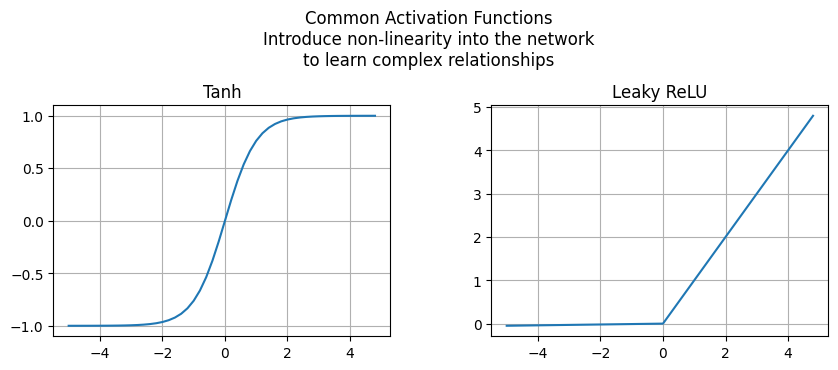

In [365]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### Calculate Outputs and Loss Using Tanh Activation

In [366]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.69463946 -0.89831156]
 [-0.05472393  0.08222722]
 [ 0.90631546  0.48494684]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 0.49096736  3.8805415 ]
 [-0.02722064 -0.32862622]
 [ 2.29757776  1.7490527 ]]

bias (3, 1):
[[-0.87775632]
 [ 0.0129395 ]
 [ 0.45091769]]

weights_x_inputs_+_bias (3, 2):
[[-0.38678896  3.00278518]
 [-0.01428113 -0.31568672]
 [ 2.74849546  2.19997039]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[-0.36858872  0.99508216]
 [-0.01428016 -0.30560164]
 [ 0.99183529  0.97574171]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.74750633 -0.14445071  0.75049391]
 [ 0.99503268  0.28301392  0.34108514]
 [-0.96486245 -0.38586406 -0.6764546 ]]

input (3, 2):
[[-0.36858872  0.99508216]
 [-0.01428016 -0.30560164]
 [ 0.99183529  0.97574171]]

weights_x_inputs (3, 2):
[[ 1.02195153  0.03260237

In [367]:
print(f'-- Neural network outputs and Loss --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err:            {err}')
print(f'err_sq:         {err_sq}')
print(f'loss_mean:      {loss_mean}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')


-- Neural network outputs and Loss --
yout:           [0.33837347 0.24896929] <-- neural network output
desired output: [1.0, -1.0]
err:            [-0.66162653  1.24896929]
err_sq:         [0.43774967 1.5599243 ]
loss_mean:      0.9988369828385484
loss_sum:       1.9976739656770968 <-- sum(prediction_error)^2


In [368]:
# save original parameters
param_org = [p.data for p in n.parameters()]

#   &nbsp;
# - How Artificial Neural Network Learns -

##### * calculate gradients (i.e. changes in Loss w.r.t. changes in each parameter)<br>* use gradients to adjust parameters in direction of less Loss<br>* repeat the steps

##### Example of calculating gradient for parameter W0<br>* calculate outputs and Loss<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate outputs and Loss<br>* calculate gradient (W0_grad = changes_in_Loss / changes_in_W0)
##### Increase W0 by small amount

In [369]:
# Increase W1 by h
h = .00001
loss_sum_before = loss_sum
print(f'loss_sum before increase Wo:  {loss_sum_before:10.7f}')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:                    {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:                     {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:                       {W0_dif:10.7f} <-- increased W0 by a small amount') 

loss_sum before increase Wo:   1.9976740
W0_before:                     0.6946395
W0_after:                      0.6946495
W0_dif:                        0.0000100 <-- increased W0 by a small amount


##### Recalculate output and Loss with small changes in W0

In [370]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.69464946 -0.89831156]
 [-0.05472393  0.08222722]
 [ 0.90631546  0.48494684]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[ 0.49098736  3.8805715 ]
 [-0.02722064 -0.32862622]
 [ 2.29757776  1.7490527 ]]

bias (3, 1):
[[-0.87775632]
 [ 0.0129395 ]
 [ 0.45091769]]

weights_x_inputs_+_bias (3, 2):
[[-0.38676896  3.00281518]
 [-0.01428113 -0.31568672]
 [ 2.74849546  2.19997039]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[-0.36857144  0.99508245]
 [-0.01428016 -0.30560164]
 [ 0.99183529  0.97574171]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.74750633 -0.14445071  0.75049391]
 [ 0.99503268  0.28301392  0.34108514]
 [-0.96486245 -0.38586406 -0.6764546 ]]

input (3, 2):
[[-0.36857144  0.99508245]
 [-0.01428016 -0.30560164]
 [ 0.99183529  0.97574171]]

weights_x_inputs (3, 2):
[[ 1.02193861  0.03260215

##### Calculate gradient

In [371]:
loss_sum_after = loss_sum
loss_sum_dif = loss_sum_after - loss_sum_before
W0_grad = loss_sum_dif / W0_dif

print(f'-- Calculate outputs and changes in Loss --')
print(f'yout:             {yout}')   
print(f'desired output:   {ys}')   
print(f'err:              {err}')
print(f'err_sq:           {err_sq}')
print(f'loss_sum_before:  {loss_sum_before}')
print(f'loss_sum_after:   {loss_sum_after}\n')
print(f'-- Calcuclate gradient --')
print(f'loss_sum_dif:     {loss_sum_dif} <-- change in loss_sum')
print(f'W0_dif:           {W0_dif} <-- change in W0')
print(f'W0_grad:          {W0_grad} <-- (changes in loss_sum) / (changes in W0), manual calculation')

-- Calculate outputs and changes in Loss --
yout:             [0.33837838 0.24896919]
desired output:   [1.0, -1.0]
err:              [-0.66162162  1.24896919]
err_sq:           [0.43774317 1.55992403]
loss_sum_before:  1.9976739656770968
loss_sum_after:   1.997667199720341

-- Calcuclate gradient --
loss_sum_dif:     -6.765956755749869e-06 <-- change in loss_sum
W0_dif:           9.99999999995449e-06 <-- change in W0
W0_grad:          -0.6765956755780661 <-- (changes in loss_sum) / (changes in W0), manual calculation


##### Calculate output and Loss with Micrograd<br>* change W0 back to initial value<br>* compare manual calculation vs Micrograd 

In [372]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# loss.backward()
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

# print(f'-- Micrograd forward pass and backward pass --')
print(f'-- Calculate neural network Loss and gradient using Micrograd --')
print(f'W0:          {n.parameters()[0].data}')
print(f'ypred_data:  {ypred_data}')
print(f'ys:          {ys}')
print(f'err_sq:      {err_sq}')
print(f'loss_mean:   {loss_mean}')
print(f'loss_sum:    {loss_sum} <-- loss_sum, Micrograd calculation same as manual calc. {loss_sum_before}')


-- Calculate neural network Loss and gradient using Micrograd --
W0:          0.6946394591187923
ypred_data:  [0.33837346660544815, 0.24896929345176647]
ys:          [1.0, -1.0]
err_sq:      [0.4377496696916921, 1.5599242959854047]
loss_mean:   0.9988369828385484
loss_sum:    1.9976739656770968 <-- loss_sum, Micrograd calculation same as manual calc. 1.9976739656770968


##### Calculate gradients and adjust parameters using Micrograd

In [373]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
print('-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --
  0      0.6946394591    -0.6766037389           0.05000         0.7284696461 <-- gradient same as manual calc. W0_grad -0.6765956756
  1     -0.8983115609    -0.3078198733           0.05000        -0.8829205673
  2     -0.8777563198    -0.3339472986           0.05000        -0.8610589548
  3     -0.0547239284    -0.6200282822           0.05000        -0.0237225143
  4      0.0822272182     0.2111849375           0.05000         0.0716679713
  5      0.0129395047    -0.2355571299           0.05000         0.0247173612
  6      0.9063154604     0.1492188623           0.05000         0.8988545173
  7      0.4849468426    -0.1096120550           0.05000         0.4904274453
  8      0.4509176944     0.0482920760           0.05000         0.4485030906
  9     -0.7475063270     1.5056888027           0.05000        -0.8227907671
 10     -0.1444507098    -0.4301520911           0.05000        -0.122943

##### Repeat the steps using Micrograd:<br>* calculate Loss<br>* calculate gradient<br>* adjust parameters in direction of less Loss

In [374]:
ypred = [n(x) for x in xs]
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss_squares = list((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss_squares)


[Value(data = 0.536915912701875), Value(data = 0.851740833194973)]


In [375]:
loss = [loss_square.data for loss_square in loss_squares]
loss_mean = np.mean(loss)
print(loss)
print(loss_mean)

[0.536915912701875, 0.851740833194973]
0.694328372948424


In [376]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  # print('-------')

ypred: [Value(data = 0.2672545375767415), Value(data = -0.07710193780950385)]
step: 0, loss: 1.388656745896848
ypred: [Value(data = 0.25498142024057185), Value(data = -0.2769883282856228)]
step: 1, loss: 1.0777985616219738
ypred: [Value(data = 0.3204910071279003), Value(data = -0.3682087633400376)]
step: 2, loss: 0.8608926381143798
ypred: [Value(data = 0.40218933769217), Value(data = -0.4375101400463519)]
step: 3, loss: 0.6737724305196009
ypred: [Value(data = 0.47885532706579564), Value(data = -0.5006084478134303)]
step: 4, loss: 0.5209836925230102
ypred: [Value(data = 0.5453504752069331), Value(data = -0.5560375243034599)]
step: 5, loss: 0.4038088702211625
ypred: [Value(data = 0.6007387317303743), Value(data = -0.6028142631801604)]
step: 6, loss: 0.3171660698733889
ypred: [Value(data = 0.645971993490803), Value(data = -0.6415250814425542)]
step: 7, loss: 0.25384009662764345
ypred: [Value(data = 0.6827174914972801), Value(data = -0.6734241383622219)]
step: 8, loss: 0.20731998360623569


##### Plot Loss

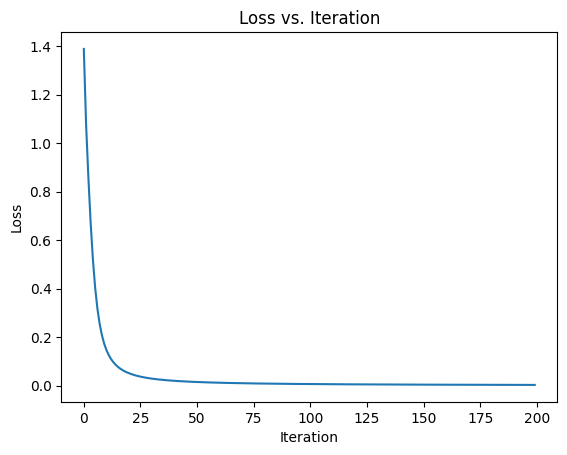

In [377]:
plot_losses(losses)

##### Results at end of iteration

In [378]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [value.data for value in ypred]

print(f'\n- Results at end of iteration -')
print(f'ypred_data: {ypred_data}')
print(f'loss: {loss.data}\n\n')

print(f'Optimized weight and bias matrices')
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)


- Results at end of iteration -
ypred_data: [0.9649086969301246, -0.9569006456364234]
loss: 0.003088953897698995


Optimized weight and bias matrices
--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[ 0.39810722 -1.08052529]
 [-0.02442978 -0.10199158]
 [ 0.85245828  0.52431053]]

input (2, 2):
[[ 2.  3.]
 [ 1. -2.]]

weights_x_inputs (3, 2):
[[-0.28431085  3.35537224]
 [-0.15085113  0.13069381]
 [ 2.22922709  1.50875379]]

bias (3, 1):
[[-1.03087210e+00]
 [-3.94258724e-04]
 [ 4.33459431e-01]]

weights_x_inputs_+_bias (3, 2):
[[-1.31518295  2.32450015]
 [-0.15124539  0.13029956]
 [ 2.66268653  1.94221323]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[-0.86558098  0.98103915]
 [-0.15010259  0.12956712]
 [ 0.99031407  0.95970913]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-1.36790051 -0.12002744  0.46236623]
 [ 0.78387333  0.30187825  0.62403732]
 [-1.24508916 -0.37830825

##### Changes in parameters after optimization

In [379]:
# save parameters
param_optmz = [p.data for p in n.parameters()]
param_comp = zip(param_org, param_optmz)

# print(f'i        param_new      param_org      param_dif')
print(f'i   param_optimized      param_org      param_dif')
for i, param_org_new in enumerate(param_comp):
  p_org = param_org_new[0]
  p_new = param_org_new[1]  
  p_dif = p_new - p_org
  print(f'{i:<4} {p_new:>14.10f} {p_org:>14.10f} {p_dif:>14.10f}')  


i   param_optimized      param_org      param_dif
0      0.3981072209   0.6946394591  -0.2965322382
1     -1.0805252901  -0.8983115609  -0.1822137292
2     -1.0308720975  -0.8777563198  -0.1531157777
3     -0.0244297787  -0.0547239284   0.0302941497
4     -0.1019915752   0.0822272182  -0.1842187934
5     -0.0003942587   0.0129395047  -0.0133337635
6      0.8524582834   0.9063154604  -0.0538571770
7      0.5243105278   0.4849468426   0.0393636853
8      0.4334594308   0.4509176944  -0.0174582637
9     -1.3679005137  -0.7475063270  -0.6203941867
10    -0.1200274420  -0.1444507098   0.0244232678
11     0.4623662259   0.7504939069  -0.2881276809
12    -0.2099691379   0.0923484040  -0.3023175419
13     0.7838733270   0.9950326815  -0.2111593545
14     0.3018782519   0.2830139174   0.0188643345
15     0.6240373157   0.3410851442   0.2829521714
16     0.8242158881   0.5397220875   0.2844938006
17    -1.2450891582  -0.9648624471  -0.2802267111
18    -0.3783082542  -0.3858640648   0.0075558106


#   &nbsp;
# - Build Same Model with PyTorch -

In [380]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)  
        return x

model = MLP_torch()

# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5]
# ]

# # desired targets
# ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# # learning rate (i.e. step size)
# learning_rate = 0.05

losses = []
for epoch in range(200):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")

Epoch 0 loss: 1.122596263885498
Epoch 10 loss: 0.7191467881202698
Epoch 20 loss: 0.2444424033164978
Epoch 30 loss: 0.027688879519701004
Epoch 40 loss: 0.0019509154371917248
Epoch 50 loss: 0.00012115032586734742
Epoch 60 loss: 7.292015652637929e-06
Epoch 70 loss: 4.3569565377765684e-07
Epoch 80 loss: 2.5967331396259397e-08
Epoch 90 loss: 1.5518324403274164e-09
Epoch 100 loss: 9.07576236386376e-11
Epoch 110 loss: 5.863753926860227e-12
Epoch 120 loss: 4.1389114358025836e-13
Epoch 130 loss: 2.3092638912203256e-13
Epoch 140 loss: 1.3145040611561853e-13
Epoch 150 loss: 1.3145040611561853e-13
Epoch 160 loss: 1.3145040611561853e-13
Epoch 170 loss: 1.3145040611561853e-13
Epoch 180 loss: 1.3145040611561853e-13
Epoch 190 loss: 1.3145040611561853e-13

Prediction:
tensor([[ 1.0000],
        [-1.0000]])
Loss: 1.3145040611561853e-13


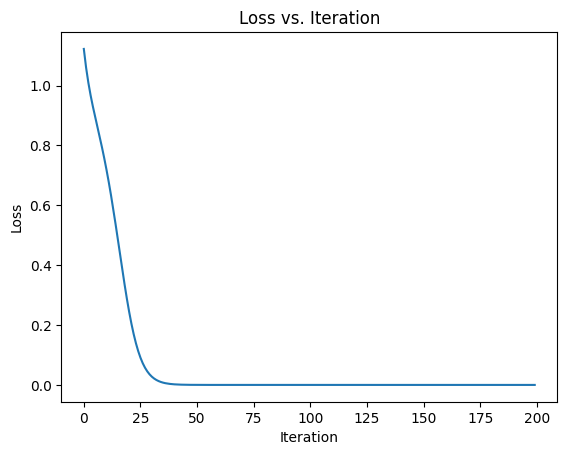

In [381]:
plot_losses(losses)

In [382]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')

# l_items is a list of [weight matrix, bias matrix, ..., weight matrix, bias matrix] 
l_items = list(model.parameters())
if len(l_items) % 2 == 0:  # True divisible by 2
  for i in range(0, len(l_items), 2):  # i: 0, 2, ..., len(l_items)-2
    if i == 0:  # use transposed t_xs as input only at the first time
      x0 = torch.clone(t_xs).detach()  # clone t_xs without autograd history
      input = torch.transpose(x0, 0, 1)  # columns of x0 becomes rows of input
    else:  # use previous output as input 
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 1.0], [3.0, -2.0]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([3, 2]):
tensor([[ 0.3252,  0.1049],
        [-0.0843, -0.9375],
        [ 0.7416, -0.3055]])

input,  torch.Size([2, 2]):
tensor([[ 2.,  3.],
        [ 1., -2.]])

w * input,  torch.Size([3, 2]):
tensor([[ 0.7553,  0.7656],
        [-1.1062,  1.6219],
        [ 1.1777,  2.8357]])

bT,  torch.Size([3, 1]):
tensor([[ 0.5018],
        [-0.0415],
        [-0.4620]])

w * input + bT,  torch.Size([3, 2]):
tensor([[ 1.2571,  1.2675],
        [-1.1477,  1.5804],
        [ 0.7158,  2.3738]])

output,  torch.Size([3, 2]):
tensor([[ 0.8503,  0.8531],
        [-0.8170,  0.9187],
        [ 0.6143,  0.9828]])


layer: 1.0,  i: 2

w,  torch.Size([3, 3]):
tensor([[-0.2244, -0.8549,  0.1353],
        [ 0.6092, -0.6606, -0.1945],
        [ 0.0384, -0.1292, -0.2148]])

input,  torch.Size([3, 2]):
tensor([[ 0.8503,  0.8531],
        [-0.8170,  0.9187],
        [ 0.6143,  0.9828]])

w * input,  torch.S

In [383]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [384]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 1.0000, -1.0000]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(1.3145e-13)

In [385]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 1.0000, -1.0000]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-4.1723e-07,  2.9802e-07]])
squared_difference: tensor([[1.7408e-13, 8.8818e-14]])


tensor(1.3145e-13)

In [386]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9999995827674866, -0.9999997019767761]

In [387]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

1.3145040611561853e-13


In [388]:
len(squared_difference)


1

In [389]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(1.3145e-13)

In [390]:
torch.sum((output - torch.tensor(ys))**2)


tensor(2.6290e-13)

##### Check Output and Gradient Calculation with PyTorch

In [391]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [392]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [393]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.5734889776
i:  1,  -0.3276196891
i:  2,   0.2110627217
i:  3,  -0.0698786414
i:  4,  -0.3892335134
---
i: 36,  -0.7802053768
i: 37,   0.0996639967
i: 38,  -0.3603184008
i: 39,   0.3767680692
i: 40,   0.2792514269


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [394]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [395]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.5734890,   w0.grad:  0.0000000
w1: -0.3276197,   w1.grad:  0.0000000
w2:  0.2110627,   w2.grad:  0.0000000
b:  -0.0698786

layer: 0, neuron 1
w0: -0.3892335,   w0.grad:  0.0000000
w1:  0.2521298,   w1.grad:  0.0000000
w2:  0.4826802,   w2.grad:  0.0000000
b:  -0.4493381

layer: 0, neuron 2
w0:  0.6423906,   w0.grad:  0.0000000
w1:  0.7909473,   w1.grad:  0.0000000
w2:  0.3486222,   w2.grad:  0.0000000
b:  -0.4706923

layer: 0, neuron 3
w0:  0.5061538,   w0.grad:  0.0000000
w1:  0.7811714,   w1.grad:  0.0000000
w2: -0.4814068,   w2.grad:  0.0000000
b:  -0.3883638

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0:  0.0538535,   w0.grad:  0.0000000
w1:  0.0746517,   w1.grad:  0.0000000
w2: -0.6536807,   w2.grad:  0.0000000
w3: -0.1540507,   w3.grad:  0.0000000
b:   0.0318015

layer: 1, neuron 1
w0: -0.6799627,   w0.grad:  0.0000000
w1: -0.8478146,   w1.grad:  0.0000000
w2:  0.0941120,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [396]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.57348898 -0.32761969  0.21106272]
 [-0.38923351  0.2521298   0.48268023]
 [ 0.64239064  0.79094735  0.34862221]
 [ 0.50615385  0.7811714  -0.4814068 ]]
b_mat(1, 4):
[[-0.06987864 -0.44933809 -0.47069227 -0.38836379]]

i: 1
w_mat(4, 4):
[[ 0.05385354  0.07465169 -0.65368074 -0.15405072]
 [-0.67996275 -0.84781463  0.09411201 -0.64597193]
 [-0.22107721  0.13212344  0.58571415 -0.45588999]
 [-0.76104917 -0.47762779 -0.60461733 -0.68218844]]
b_mat(1, 4):
[[ 0.03180146 -0.49142179  0.42856394  0.82226321]]

i: 2
w_mat(1, 4):
[[-0.78020538  0.099664   -0.3603184   0.37676807]]
b_mat(1, 1):
[[0.27925143]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [397]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.57348898 -0.32761969  0.21106272]
 [-0.38923351  0.2521298   0.48268023]
 [ 0.64239064  0.79094735  0.34862221]
 [ 0.50615385  0.7811714  -0.4814068 ]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[-0.04694383  2.15361798]
 [-0.50475785 -1.17849023]
 [ 3.30900112  1.31053567]
 [ 3.83722869  0.49658674]]

bias (4, 1):
[[-0.06987864]
 [-0.44933809]
 [-0.47069227]
 [-0.38836379]]

weights_x_inputs_plus_bias (4, 2):
[[-0.11682248  2.08373934]
 [-0.95409594 -1.62782831]
 [ 2.83830885  0.8398434 ]
 [ 3.44886491  0.10822296]]

output (4, 2):
[[-0.11629392  0.9694901 ]
 [-0.74163176 -0.92575169]
 [ 0.99317314  0.68572611]
 [ 0.99798189  0.10780242]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.05385354  0.07465169 -0.65368074 -0.15405072]
 [-0.67996275 -0.84781463  0.09411201 -0.64597193]
 [-0.22107721  0.13212344  0.58571415 -0.45588999]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [398]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.545074010720868, 0.41128196412304]
ys:                 [1.0, -1.0]
loss_data:          2.198674437980583


#### Micrograd backward pass and update parameters

In [399]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.5734889776     0.2535063992           0.05000         0.5608136576
  1     -0.3276196891     0.6238589353           0.05000        -0.3588126358
  2      0.2110627217    -0.2153347765           0.05000         0.2218294606
  3     -0.0698786414     0.1488985938           0.05000        -0.0773235711
  4     -0.3892335134    -0.1558441938           0.05000        -0.3814413037
  5      0.2521298016     0.3946476670           0.05000         0.2323974182
  6      0.4826802288    -0.1505920695           0.05000         0.4902098323
  7     -0.4493380860    -0.0207935553           0.05000        -0.4482984083
  8      0.6423906390     0.0977329598           0.05000         0.6375039910
  9      0.7909473487    -0.0289055158           0.05000         0.7923926245
 10      0.3486222068     0.0149535039           0.05000         0.3478745316
 11     -0.4706922713     0.0329114840

### Improve Prediction with Parameter Iteration 

In [400]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.41568862079163815), Value(data = 0.0866742924651325)]
step: 0, loss: 1.5222808057769743
-------
ypred: [Value(data = 0.3943796730871835), Value(data = -0.2090068029530436)]
step: 1, loss: 0.9924462181445517
-------
ypred: [Value(data = 0.47863360219562223), Value(data = -0.3824530957405317)]
step: 2, loss: 0.6531870997199656
-------
ypred: [Value(data = 0.5478721831267924), Value(data = -0.4982701842606499)]
step: 3, loss: 0.45615237079237503
-------
ypred: [Value(data = 0.6034646599961827), Value(data = -0.5751622442684212)]
step: 4, loss: 0.3377273945669876
-------
ypred: [Value(data = 0.6469947722088242), Value(data = -0.6294506725108318)]
step: 5, loss: 0.26191949495057476
-------
ypred: [Value(data = 0.6813163632232875), Value(data = -0.6697644964614673)]
step: 6, loss: 0.21061474814657988
-------
ypred: [Value(data = 0.7088324817660913), Value(data = -0.7008922054956199)]
step: 7, loss: 0.17424399640776805
-------
ypred: [Value(data = 0.73130175287686), Val

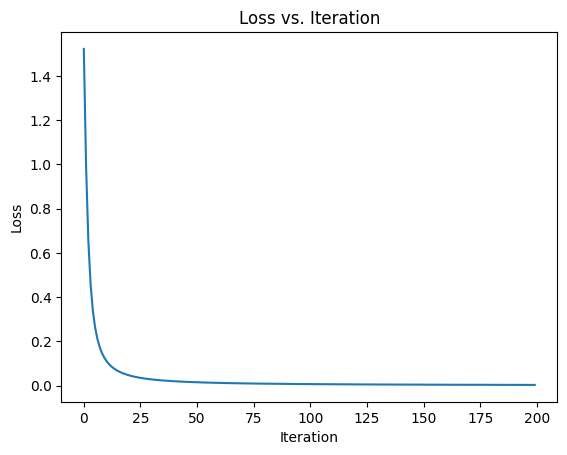

In [401]:
plot_losses(losses)

### Build same model with pyTorch 

In [402]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 0.8234934210777283
Epoch 10 loss: 0.08245433866977692
Epoch 20 loss: 0.001991106430068612
Epoch 30 loss: 4.7099150833673775e-05

Prediction:
tensor([[ 0.9998],
        [-0.9985]])
Loss: 1.6571417518207454e-06


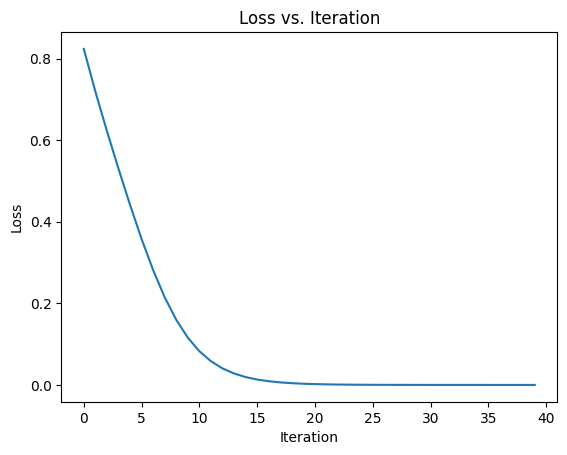

In [403]:
plot_losses(losses)

In [404]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.1008, -0.6119,  0.3991],
        [-0.1323,  0.7182,  0.5079],
        [-0.3109,  0.1364, -0.4900],
        [ 0.2303, -0.4363, -0.4952]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-2.4363,  0.5090],
        [ 1.3819, -0.8612],
        [ 0.2773, -1.3140],
        [-0.3531,  0.8795]])

bT,  torch.Size([4, 1]):
tensor([[ 0.1966],
        [-0.2048],
        [ 0.0044],
        [ 0.0391]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-2.2397,  0.7056],
        [ 1.1770, -1.0660],
        [ 0.2817, -1.3096],
        [-0.3139,  0.9186]])

output,  torch.Size([4, 2]):
tensor([[-0.9776,  0.6079],
        [ 0.8265, -0.7880],
        [ 0.2744, -0.8642],
        [-0.3040,  0.7253]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.0435,  0.363

In [405]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [406]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9998, -0.9985]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(2.2852e-06)

In [407]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9998, -0.9985]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0002,  0.0015]])
squared_difference: tensor([[4.3248e-08, 2.2420e-06]])


tensor(1.1426e-06)

In [408]:
difference
len(squared_difference)

1

In [409]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(1.1426e-06)

In [410]:
torch.sum((output - torch.tensor(ys))**2)

tensor(2.2852e-06)